# $E_{\text{peak}} - E_{\text{iso}}$ correlation

We have already performed a fit on the $E_\text{peak} - E_\text{iso}$ correlation, and, as mentioned in [Epeak_Eiso_correlation.ipynb](https://github.com/joanalnu/OAB-INAF/blob/main/Epeak_Eiso_correlation.ipynb) this relation between GRB properties can be used to constrain cosmological parameters. Namely, this is so because the isotropic equivalent energy $E_\text{iso}$ is derived from the flux $F$ by correcting for the distance (spherical geometry) and duration of the transient event.
$$E_\text{iso} = 4\pi D_L^2 S /(1+z)$$
Here, $S$ is the fluence (the time integrated flux $S = \lim_{\Delta t \to \infty} F\times t/(1+z) = \int^t Fdt$) and $D_L$ is the luminosity distance. This variable depends on a specific cosmology $\Omega$ and can be defined for a flat  Universe ($\Omega_k = 0$) as
$$D_L(z) = (1+z) \frac{c}{H_0} \int^z \frac{dz^\prime}{\sqrt{\Omega_{DE} + \Omega_m(1+z)^3}}$$
, neglecting the contribution of radiation $\Omega_R \sim 0.01$, $\implies \Omega = \Omega_{DE} + \Omega_m = 1$.

Given these equations, one can derive different $E_\text{iso}$ for different cosmologies, shifting the scatter points for the $E_\text{peak}-E_\text{iso}$ correlation. This correlation will have different values for the free parameters $(m,k)$, assuming ($\log E_\text{peak} = m\times \log E_\text{iso} + k$ depending on the cosmology. Thus, we can define a parameter grid with $(\Omega_{DE},\Omega_m)$ and computing the scatter of the fit with the data, i.e., creating a $\chi^2 (\Omega_{DE},\Omega_m)$ surface. Assuming that this is a physical correlation, the minimum of $\chi^2$ (indicating a less-scattered fit) will point the 'best cosmology.'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:
# read data
df = pd.read_csv('table.csv')

def kev_to_ergs(col):
    # 1 erg = 10**-3 * 6.242*10**11 keV
    return np.array([val*6.242*10**8 for val in col])

Epeak = np.log10(df['Epeak'])
Epeak_err = np.log10(df['Epeak_err'])
z = df['z']
S = df['Fluence'] # ergs/cm2
S_err = df['Fluence_err']

In [3]:
import numpy as np
from scipy.integrate import quad

# Constants and equations
# Option 1: Use H0 in km/s/Mpc (more standard)
H0_kmsMpc = 70.0  # km/s/Mpc
c = 29979245800  # cm/s

# Convert H0 to cgs units: H0 [s^-1] = H0 [km/s/Mpc] * (km/Mpc to 1/s conversion)
# 1 Mpc = 3.086e24 cm, so H0_cgs = H0_kmsMpc * 1e5 / 3.086e24
H0_cgs = H0_kmsMpc * 1e5 / 3.086e24  # s^-1

# Predefined flat cosmology
Om_default = 0.3
Ode_default = 0.7

def luminosity_distance(redshift, Ho=H0_cgs, O_m=Om_default, O_DE=Ode_default):
    """
    Calculate luminosity distance for given redshift(s) and cosmological parameters.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    Ho : float
        Hubble constant in cgs units (s^-1)
    O_m : float
        Matter density parameter
    O_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Luminosity distance in cm
    """
    def luminosity_distance_single(z, Ho=Ho, O_m=O_m, O_DE=O_DE):
        def integrand(z_prime, O_m=O_m, O_DE=O_DE):
            return 1/np.sqrt(O_m*(1+z_prime)**3 + O_DE)

        integral, _ = quad(integrand, 0, z, args=(O_m, O_DE))
        return (c * (1+z)/Ho) * integral

    # Handle both single values and arrays
    if np.isscalar(redshift):
        return luminosity_distance_single(redshift, Ho, O_m, O_DE)
    else:
        return np.array([luminosity_distance_single(z_i, Ho, O_m, O_DE) for z_i in redshift])

def isotropic_equivalent_energy(redshift, fluence, H0=H0_cgs, Omega_m=Om_default, Omega_DE=Ode_default):
    """
    Calculate the isotropic equivalent energy.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    fluence : float or array
        Observed fluence (should be in erg/cm^2)
    H0 : float
        Hubble constant in cgs units (s^-1)
    Omega_m : float
        Matter density parameter
    Omega_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Log10 of isotropic equivalent energy
    """
    d_L = luminosity_distance(redshift, H0, Omega_m, Omega_DE)
    numerator = 4.0 * np.pi * (d_L**2) * fluence
    return np.log10(numerator / (1 + redshift))

# Alternative version using H0 in km/s/Mpc directly (avoiding unit conversion issues)
def luminosity_distance_kmsMpc(redshift, Ho=70.0, O_m=0.3, O_DE=0.7):
    """
    Calculate luminosity distance using H0 in km/s/Mpc.
    Returns distance in Mpc.
    """
    def luminosity_distance_single(z, Ho=Ho, O_m=O_m, O_DE=O_DE):
        def integrand(z_prime, O_m=O_m, O_DE=O_DE):
            return 1/np.sqrt(O_m*(1+z_prime)**3 + O_DE)

        integral, _ = quad(integrand, 0, z, args=(O_m, O_DE))
        c_kmsMpc = 299792.458  # km/s
        return (c_kmsMpc * (1+z)/Ho) * integral  # Result in Mpc

    if np.isscalar(redshift):
        return luminosity_distance_single(redshift, Ho, O_m, O_DE)
    else:
        return np.array([luminosity_distance_single(z_i, Ho, O_m, O_DE) for z_i in redshift])

def isotropic_equivalent_energy_kmsMpc(redshift, fluence, H0=70.0, Omega_m=0.3, Omega_DE=0.7):
    """
    Calculate isotropic equivalent energy using H0 in km/s/Mpc.

    Parameters:
    -----------
    fluence : float or array
        Observed fluence in erg/cm^2

    Returns:
    --------
    float or array
        Log10 of isotropic equivalent energy in erg
    """
    d_L_Mpc = luminosity_distance_kmsMpc(redshift, H0, Omega_m, Omega_DE)
    d_L_cm = d_L_Mpc * 3.086e24  # Convert Mpc to cm
    numerator = 4.0 * np.pi * (d_L_cm**2) * fluence
    return np.log10(numerator / (1 + redshift))

# Test the functions
if __name__ == "__main__":
    # Test with sample data
    z_test = np.array([0.1, 0.5, 1.0, 2.0])
    fluence_test = np.array([1e-6, 1e-7, 1e-8, 1e-9])  # erg/cm^2

    print("Testing luminosity distance:")
    d_L = luminosity_distance_kmsMpc(z_test)
    print(f"Redshifts: {z_test}")
    print(f"Distances (Mpc): {d_L}")

    print("\nTesting isotropic equivalent energy:")
    E_iso = isotropic_equivalent_energy_kmsMpc(z_test, fluence_test)
    print(f"Log10(E_iso): {E_iso}")

Testing luminosity distance:
Redshifts: [0.1 0.5 1.  2. ]
Distances (Mpc): [  460.29993639  2832.9380939   6607.65761177 15539.58622323]

Testing isotropic equivalent energy:
Log10(E_iso): [49.36269085 49.80638462 49.41706677 48.98375935]


Above, we have read the data and defined key constants and functions, such as computing the luminosity distance and isotropic equivalent energy for a cosmology. Next, we'll try plotting $E_{\text{iso}, \bar{\Omega}}$ vs. $E_\text{iso}$ (from the table). Note that, until now, we have used a standard flat cosmology $h = \Omega_{DE} = 0.7$.

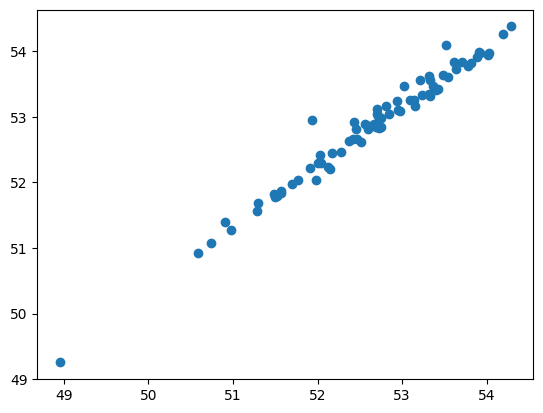

In [4]:
Eiso = isotropic_equivalent_energy(z, S, H0=H0_cgs, Omega_m=0.3, Omega_DE=0.7)
plt.figure()
plt.scatter(Eiso, np.log10(df['Eiso']))

 Since the line of points is not exactly straight (has some noise), I want to define a simple model $E_{\text{iso}, \bar{\Omega}} = k \times E_\text{iso}$, to find the proportionality factor $k$. In addition, the standard deviation and $\chi^2$ value are also computed.

Text(0, 0.5, '$E_\\text{iso}$')

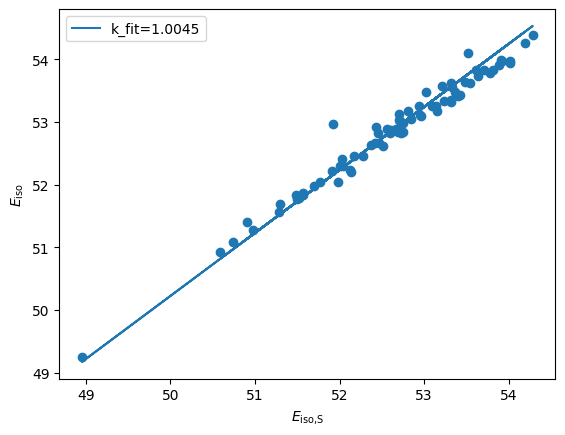

In [5]:
k = np.linspace(0.5,1.5,1000)
G = np.array([np.sum((Eiso*k_i - np.log10(df['Eiso']))**2) for k_i in k])
k_fit = k[np.unravel_index(np.argmin(G), G.shape)]

plt.figure()
plt.scatter(Eiso, np.log10(df['Eiso']))
plt.plot(Eiso, k_fit*Eiso, label=f'k_fit={k_fit:.4f}')
plt.legend()
plt.xlabel(r'$E_\text{iso,S}$')
plt.ylabel(r'$E_\text{iso}$')

Let's try to compute the relation between $E_\text{iso}$ and $E_\text{peak}$ from the isotropic equivalent energy derived from the fluence $S$ data in the table.

0.43434343434343436 -20.404040404040405


Text(0, 0.5, '')

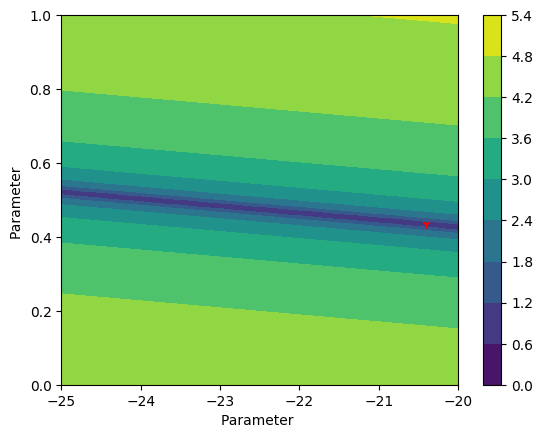

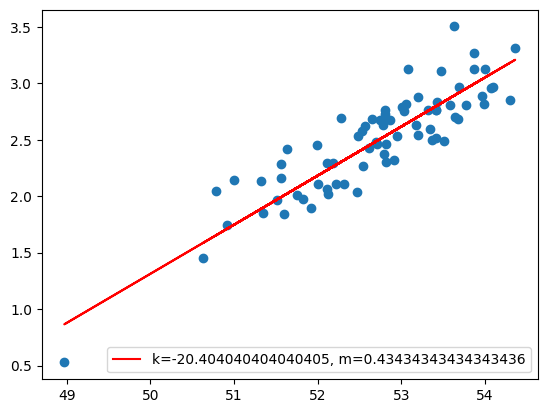

In [6]:
# let's try for Om=0.2 and Ode=0.8
isotropic_model = isotropic_equivalent_energy(df['z'], df['Fluence'], H0=H0_cgs, Omega_m=0.2, Omega_DE=0.8)
peak = Epeak

def GoF(m,k, x, y):
    """
    Goodness of fit following the chi-squared formula
    :param m: slope
    :param k: y-axis cut
    :param x: x-values
    :param y: y-values
    :return: chi-squared value
    """
    model = m*x + k
    chi_squared = np.sum((y-model)**2)
    return chi_squared

# Define parameter ranges
k = np.linspace(-25.,-20.,100) # from the previous scatter plot, we can infer that the y-axis cut is around -25 and -20
m = np.linspace(0.0,1.0,100) # the slope must be positive

G = np.zeros([len(m), len(k)]) # G[i,j] corresponds to m[i], k[j]
for i in range(len(m)):
    for j in range(len(k)):
        G[i,j] = GoF(m[i], k[j], x=isotropic_model, y=Epeak)

# extract best fit parameters
best_fit = np.argmin(G)
m_index, k_index = np.unravel_index(best_fit, G.shape)
m_fit, k_fit = m[m_index], k[k_index]
print(m_fit, k_fit)

plt.figure()
plt.contourf(k, m, np.log10(G))#, levels=50)
plt.colorbar()
plt.xlabel(r'Parameter ')
plt.ylabel(r'Parameter ')
plt.scatter(k_fit, m_fit, marker='1', color='r')


plt.figure()
plt.scatter(isotropic_model, Epeak)
plt.plot(isotropic_model, k_fit+isotropic_model*m_fit, label=f'k={k_fit}, m={m_fit}', color='r')
# plt.plot(Eiso, -24+Eiso*0.5, color='g', label=f'k={-24}, m={0.5}') # line used to calibrate the parameter space
plt.legend()
plt.xlabel(r'')
plt.ylabel(r'')

0.43434343434343436 -20.353535353535353


Text(0, 0.5, '')

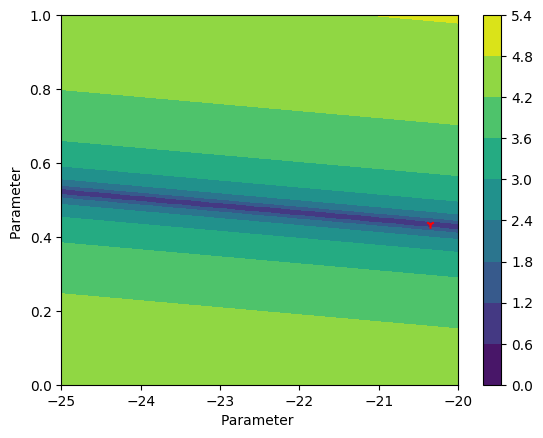

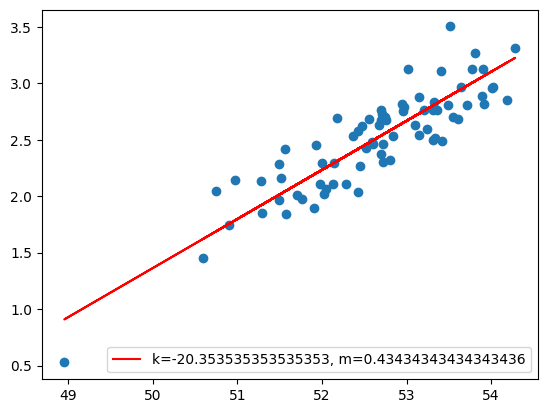

In [7]:
def GoF(m,k, x=Eiso, y=Epeak):
    """
    Goodness of fit following the chi-squared formula
    :param m: slope
    :param k: y-axis cut
    :param x: x-values
    :param y: y-values
    :return: chi-squared value
    """
    model = m*x + k
    chi_squared = np.sum((y-model)**2)
    return chi_squared


# Define parameter ranges
k = np.linspace(-25.,-20.,100) # from the previous scatter plot, we can infer that the y-axis cut is around -25 and -20
m = np.linspace(0.0,1.0,100) # the slope must be positive

G = np.zeros([len(m), len(k)]) # G[i,j] corresponds to m[i], k[j]
for i in range(len(m)):
    for j in range(len(k)):
        G[i,j] = GoF(m[i], k[j], x=Eiso, y=Epeak)


# extract best fit parameters
best_fit = np.argmin(G)
m_index, k_index = np.unravel_index(best_fit, G.shape)
m_fit, k_fit = m[m_index], k[k_index]
print(m_fit, k_fit)

plt.figure()
plt.contourf(k, m, np.log10(G))#, levels=50)
plt.colorbar()
plt.xlabel(r'Parameter ')
plt.ylabel(r'Parameter ')
plt.scatter(k_fit, m_fit, marker='1', color='r')


plt.figure()
plt.scatter(Eiso, Epeak)
plt.plot(Eiso, k_fit+Eiso*m_fit, label=f'k={k_fit}, m={m_fit}', color='r')
# plt.plot(Eiso, -24+Eiso*0.5, color='g', label=f'k={-24}, m={0.5}') # line used to calibrate the parameter space
plt.legend()
plt.xlabel(r'')
plt.ylabel(r'')

/var/folders/lq/7_q5kjhn1pzgzvpl0fk8y5mc0000gp/T/ipykernel_99123/1848835350.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/np.sqrt(O_m*(1+z_prime)**3 + O_DE)


Text(0, 0.5, '$E_\\text{peak}$')

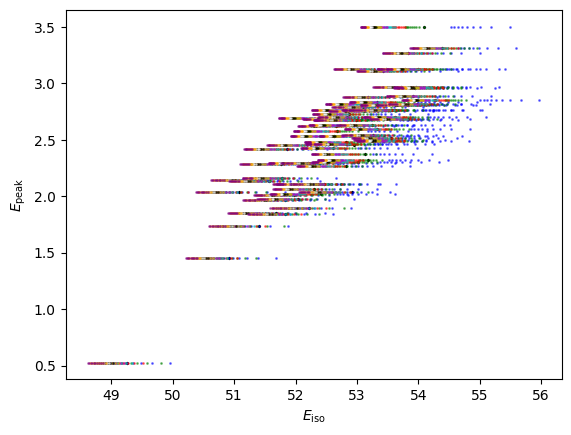

In [9]:
plt.figure()
plt.scatter(np.log10(df['Eiso']), Epeak, color='black', s=2, marker='x')

Om = np.linspace(0.0,1.0,10)
Ode = np.linspace(0.0,1.0,10)

colors = [
    'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w',
    'orange', 'purple', 'brown', 'pink', 'gray',
    'lightblue', 'lightgreen', 'lightcoral', 'gold',
    'navy', 'teal', 'lavender', 'violet', 'indigo',
    'crimson', 'salmon', 'khaki', 'beige', 'coral',
    'chocolate', 'tan', 'peachpuff', 'plum', 'orchid',
    'sienna', 'slategray', 'darkgreen', 'darkred',
    'darkblue', 'darkviolet', 'mediumvioletred',
    'mediumseagreen', 'mediumslateblue', 'mediumturquoise',
    'mediumorchid', 'lightseagreen', 'lightsteelblue',
    'lightsalmon', 'lightpink', 'lightyellow', 'darkkhaki',
    'darkslategray', 'forestgreen', 'seashell', 'snow',
    'mistyrose', 'honeydew', 'lavenderblush', 'lightcyan',
    'lightgoldenrodyellow', 'lightcoral'
]

for i in range(len(Om)):
    for j in range(len(Ode)):
        Eiso_S = isotropic_equivalent_energy(z, S, H0_cgs, Om[i], Ode[j])
        plt.scatter(Eiso_S, Epeak, color=colors[i], s=1, alpha=0.5)

plt.xlabel(r'$E_\text{iso}$')
plt.ylabel(r'$E_\text{peak}$')